In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [36]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [37]:
manip = ExperimentClass.Experiment("20230829_activation","PSI", DataType=".csv", sep = ';')
#Intensities = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
Intensities = [0, 10, 20, 30, 40, 60, 90]

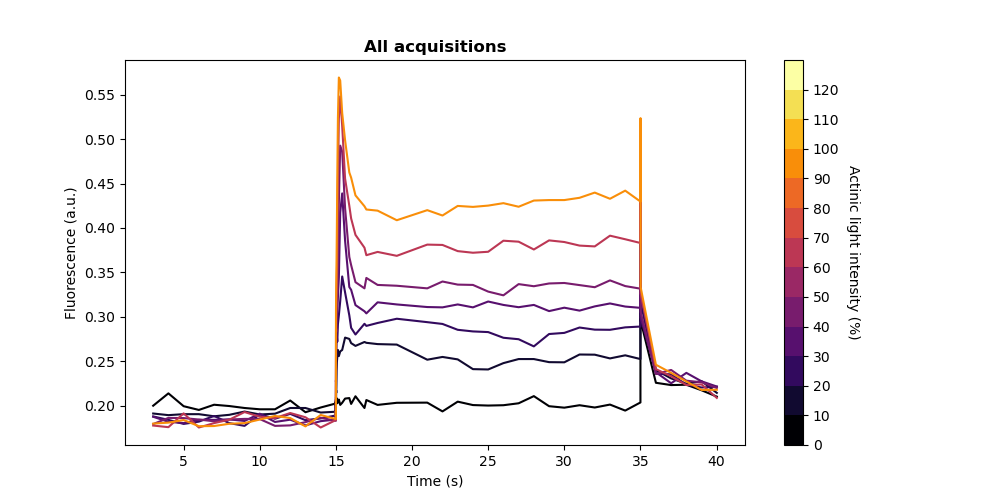

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
act = np.arange(0, 130, 10)
cmap = plt.cm.get_cmap('inferno', len(act))
for i, k in enumerate(manip.records[::-1]):
    ax.plot(manip.Time, manip.Data[k], color = cmap(tools.closest_index(act,Intensities[i])), label = f"{Intensities[i]}%")

cmap_legend = True
if cmap_legend:
# add cmap legend
    sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(act)))
    cbar.ax.set_yticklabels(act)
    cbar.ax.set_ylabel('Actinic light intensity (%)', rotation=270, labelpad=15)
else:
    ax.legend(title = "Actinic light intensity", loc = 'upper left', borderaxespad = 3)
    fig.set_figwidth(10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('All acquisitions', fontweight = 'bold')

fig.savefig(f"{manip.fig_folder}/All_acquisitions.png", dpi=300)


In [39]:
tools.closest_index(act,Intensities[i])

9

In [40]:
manip.records[::-1]

['AL0', 'AL10', 'AL20', 'AL30', 'AL40', 'AL60', 'AL90']

In [41]:
def compute_params(Experiment_df, Intensities):
    
    t_F0 = [0, 15]                  # time interval for F0 calculation in seconds
    t_Fstat = [22, 35]              # time interval for Fstat calculation in seconds
    t_Fmax = [35.004, 35.007]       # time interval for Fmax calculation in seconds
    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Experiment_df.records[::-1]):
        F_max.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fmax[0])[0][0] :np.where(Experiment_df.Time>= t_Fmax[1])[0][0]]))
        F_0.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_F0[0])[0][0] :np.where(Experiment_df.Time>= t_F0[1])[0][0]]))
        F_stat.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fstat[0])[0][0] :np.where(Experiment_df.Time>= t_Fstat[1])[0][0]]))
        phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
        phi_0.append((F_max[i] - F_0[i]) / F_max[i])
        NPQ.append((F_max[0] - F_max[i])/F_max[i])
        ETR.append(phi_stat[i] * Intensities[i])
        
    norm = F_max[0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
    F_0 = list(np.array(F_0)/norm)
        
    params_df = pd.DataFrame({'Record': Experiment_df.records[::-1], 'Actinic': Intensities, 'F_max': F_max, 'F_stat': F_stat, 'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df, norm
    

In [42]:
params_df, norm = compute_params(manip, Intensities)
norm

0.4839475

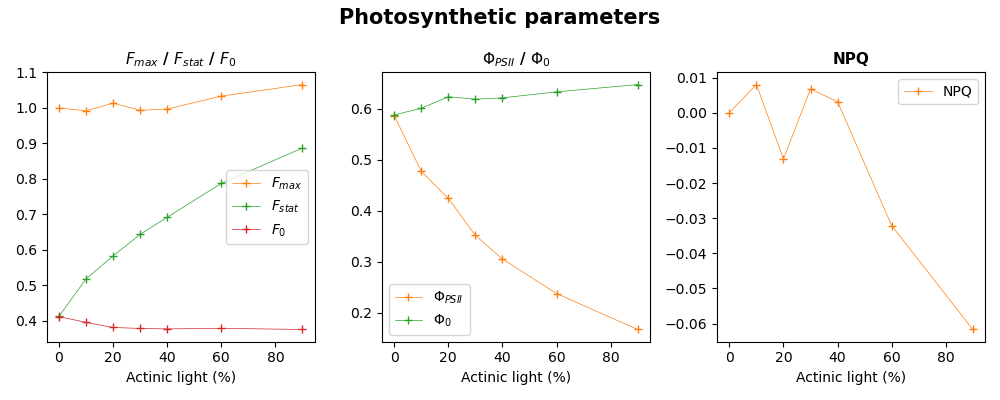

In [43]:
fig, ax = plt.subplots(1,3, figsize = (10,4))
fig.suptitle("Photosynthetic parameters", fontsize = 15, fontweight = 'bold')

ax[0].plot(params_df.Actinic, params_df.F_max, '+-', linewidth = 0.5, color = 'C1', label = '$F_{max}$')
ax[0].plot(params_df.Actinic, params_df.F_stat, '+-', linewidth = 0.5, color = 'C2', label = '$F_{stat}$')
ax[0].plot(params_df.Actinic, params_df.F_0, '+-', linewidth = 0.5, color = 'C3', label = '$F_{0}$')

ax[0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')

ax[1].plot(params_df.Actinic, params_df.phi_stat, '+-', linewidth = 0.5, label = '$Φ_{PSII}$', color = 'C1')
ax[1].plot(params_df.Actinic, params_df.phi_0, '+-', linewidth = 0.5, label = '$Φ_{0}$', color = 'C2')

ax[1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')

ax[2].plot(params_df.Actinic, params_df.NPQ, '+-', linewidth = 0.5, label = 'NPQ', color = 'C1')

ax[2].set_title('NPQ', fontsize = 11, fontweight = 'bold')

ax = ax.flatten()
    
[ax.set_xlabel("Actinic light (%)", fontsize = 10) for ax in ax]
[ax.legend() for ax in ax]


fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Parameters.png", dpi=300)

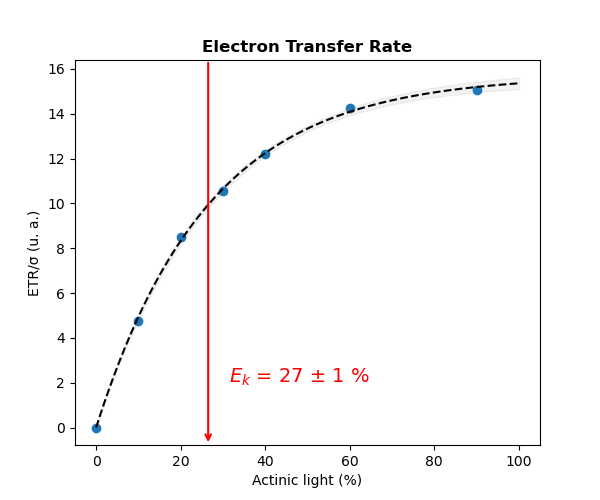

In [44]:
light = params_df.Actinic.tolist()
ETR = params_df.ETR.tolist()

fig, ax = plt.subplots(figsize = (6,5))
ax.set_title("Electron Transfer Rate", fontweight = 'bold')
ax.plot(light, ETR, 'o')

popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 100, 100, p0 = [15, 20])

err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')

ax.plot(xfit, yfit, '--', color ='k', linewidth = 1.5)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax.annotate("", xy=(Ek, ax.get_ylim()[0]), xytext=(Ek, ax.get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 1.5))
#ax.fill_betweenx(ax.get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax.text(Ek + 5, 2, f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} %", fontsize = 14, color = "red")
ax.set_xlabel("Actinic light (%)")
ax.set_ylabel("ETR/σ (u. a.)")

fig.savefig(f"{manip.fig_folder}/ETR.png", dpi=300)

In [45]:
params_df.Actinic.tolist()

[0, 10, 20, 30, 40, 60, 90]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


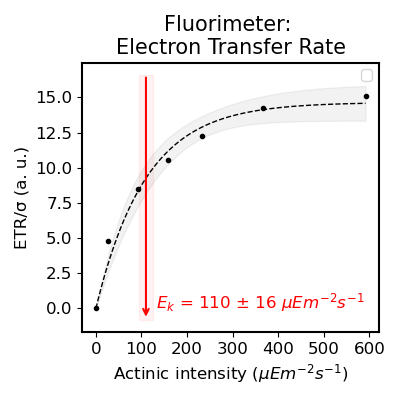

In [46]:
light = [0, 26.9, 93.1, 157.4, 232.5, 365.5, 591.3]
fig, ax = plt.subplots(figsize = (4,4))
ax.set_title("Fluorimeter: Electron Transfer Rate")
ax.plot(light, ETR, 'o', color = 'k', markersize = 3)

popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, light[0], light[-1], 100, p0 = [200, 200])

err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = 'k')

ax.plot(xfit, yfit, '--', color ='k', linewidth = 1)
Ek = popt[1]
Ek_err = np.sqrt(np.diag(pcov))[1]
ax.annotate("", xy=(Ek, ax.get_ylim()[0]), xytext=(Ek, ax.get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 1.5))
ax.fill_betweenx(ax.get_ylim(), Ek - Ek_err, Ek + Ek_err, color='red', alpha=0.05)
ax.text(Ek + 0.2*Ek, 0, f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f}"+" $µEm^{-2}s^{-1}$", fontsize = 12, color = "red")

ax = tools.poster_axes(ax, xlabel= "Actinic intensity ($µEm^{-2}s^{-1}$)", ylabel = "ETR/σ (a. u.)", title = "Fluorimeter: \nElectron Transfer Rate", labelsize= 12)
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/ETR_poster.png", dpi=300)

In [12]:

acq_settings = {
    'frequency': [128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
    'period': [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128],
    'nb_period': [4000, 2000, 1000, 500, 250, 200, 200, 200, 100, 100, 100, 50, 20, 20, 10],
    'time': [31.25, 31.25, 31.25, 31.25, 31.25, 50, 100, 200, 200, 400, 800, 800, 640, 1280, 1280],
    'DAQ_rate': [16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
}

acq_settings = pd.DataFrame(acq_settings)

print(df)


NameError: name 'df' is not defined

In [ ]:

acq_settings = {
    'frequency': [128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
    'period': [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128],
    'nb_period': [4000, 2000, 1000, 500, 250, 200, 200, 200, 100, 100, 100, 50, 20, 20, 10],
    'time': [31.25, 31.25, 31.25, 31.25, 31.25, 50, 100, 200, 200, 400, 800, 800, 640, 1280, 1280],
    'DAQ_rate': [16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
}

acq_settings = pd.DataFrame(acq_settings)

print(df)


     frequency      period  nb_period     time  DAQ_rate
0   128.000000    0.007812       4000    31.25     16384
1    64.000000    0.015625       2000    31.25      8192
2    32.000000    0.031250       1000    31.25      4096
3    16.000000    0.062500        500    31.25      2048
4     8.000000    0.125000        250    31.25      1024
5     4.000000    0.250000        200    50.00       512
6     2.000000    0.500000        200   100.00       256
7     1.000000    1.000000        200   200.00       128
8     0.500000    2.000000        100   200.00        64
9     0.250000    4.000000        100   400.00        32
10    0.125000    8.000000        100   800.00        16
11    0.062500   16.000000         50   800.00         8
12    0.031250   32.000000         20   640.00         4
13    0.015625   64.000000         20  1280.00         2
14    0.007812  128.000000         10  1280.00         1
